In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

class StopExecution(Exception):
    def _render_traceback_(self):
        return []



In [2]:
import sys
sys.path.append("..")
import pickle as pkl
import hist
from analyzer.core import AnalysisResult
from analyzer.datasets import SampleManager
import math
import torch
import gpytorch
from torch.masked import masked_tensor, as_masked_tensor
import numpy as np

In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
import matplotlib.pyplot as plt
from analyzer.plotting.plots_1d import drawAs1DHist
from analyzer.plotting.plots_2d import drawAs2DHist, addTitles2D
from analyzer.plotting.plottables import PlotObject
from analyzer.plotting.mplstyles import loadStyles
import analyzer.plotting as plot
loadStyles()

In [5]:
from fitting import regression



In [6]:
res = AnalysisResult.fromFile("../results/control.pkl")

In [7]:
sample_manager = SampleManager()
sample_manager.loadSamplesFromDirectory("../datasets")

In [282]:
hists = res.getMergedHistograms(sample_manager)
res_sig = AnalysisResult.fromFile("../results/control.pkl")
sig_reg_hists = res_sig.getMergedHistograms(sample_manager)

In [391]:
bkg_name="CR0b_Data2018"
complete_hist = hists["ratio_m14_vs_m24"]
narrowed = hist
#orig =  complete_hist[...,hist.loc(1100):hist.loc(2500),hist.loc(400):hist.loc(2000)]
#orig =  complete_hist[...,hist.loc(0):hist.loc(3000),hist.loc(0):hist.loc(1)]
orig =  complete_hist[...,hist.loc(1150):hist.loc(3000),hist.loc(0.4):hist.loc(1)]
#orig = orig / orig.values().max()
#orig =  complete_hist[...,hist.loc(1150):hist.loc(3000),hist.loc(400):hist.loc(3000)]#orig =  complete_hist[...,hist.loc(0):hist.loc(3000),hist.loc(0):hist.loc(3000)]
narrowed = orig
#narrowed = orig[...,::hist.rebin(15),::hist.rebin(12)]
narrowed = orig[...,::hist.rebin(2),::hist.rebin(2)]

qcd_hist = narrowed[bkg_name,...]
orig_qcd_hist = orig[bkg_name,...]

#sig_hist = narrowed["signal_312_1500_900",...]

qcd_hist = narrowed[bkg_name,...] 


In [392]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

def addColorbar(ax, vals):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(vals, cax=cax)
    cax.get_yaxis().set_offset_position("left")
    ax.cax = cax

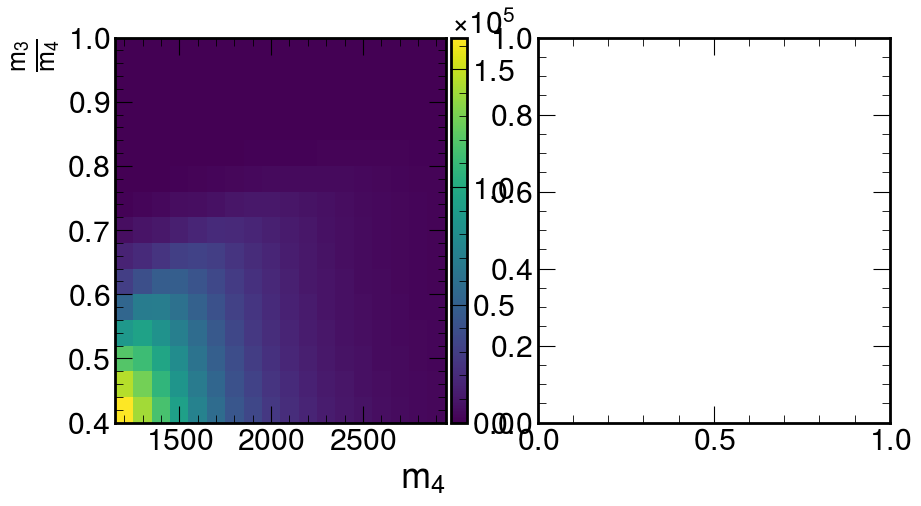

In [393]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
_ = drawAs2DHist(ax[0], PlotObject.fromHist(qcd_hist))
#_ = drawAs2DHist(ax[1], PlotObject.fromHist(sig_hist))

In [463]:
#sig_values = torch.from_numpy(sig_hist.values()).T
#(train, test), centers_mask = regression.preprocessHistograms(qcd_hist, [(0,0),(0.0,0.0)])
window = [(1300,1550),(0.55,0.65)]
#window=None
(raw_train, raw_test), (train, test), centers_mask, value_scale = regression.preprocessHistograms(qcd_hist, window)



torch.Size([266])
torch.Size([270])


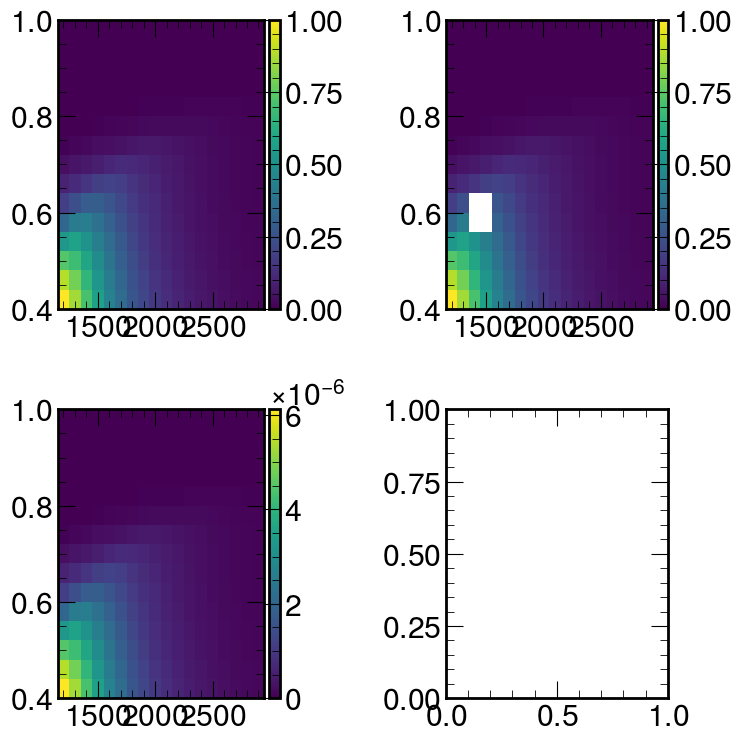

In [468]:
fig,ax = plt.subplots(2,2, figsize=(8,8))
def simpleGrid(ax, edges,iny):
    X,Y = np.meshgrid(*edges)
    z=iny
    Z=z.reshape(len(edges[1])-1,len(edges[0])-1)
    f = ax.pcolormesh(X,Y,Z)
    addColorbar(ax,f)
    return f


print(train.outputs.shape)
print(test.outputs.shape)
simpleGrid(ax[0,0],test.edges, test.outputs)
simpleGrid(ax[0,1],test.edges, np.ma.masked_where(torch.flatten(centers_mask), test.outputs))
simpleGrid(ax[1,0],test.edges, test.variances)

#drawAs2DHist(ax[1,1], PlotObject.fromHist(sig_hist))
fig.tight_layout()

In [465]:
#sig_values = torch.from_numpy(sig_hist.values()).T
#(train, test), centers_mask = regression.preprocessHistograms(qcd_hist, [(0,0),(0.0,0.0)])
window = [(1300,1550),(0.55,0.65)]
#window=None
(raw_train, raw_test), (train, test), centers_mask, value_scale = regression.preprocessHistograms(qcd_hist, window)



Optimizing Hyperparams... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:02

mean_module.raw_constant Parameter containing:
tensor(0.2419, requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-2.7341, requires_grad=True)
covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[2.3400, 2.5946]], requires_grad=True)


/srv/notebooks/../fitting/plot_tools.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


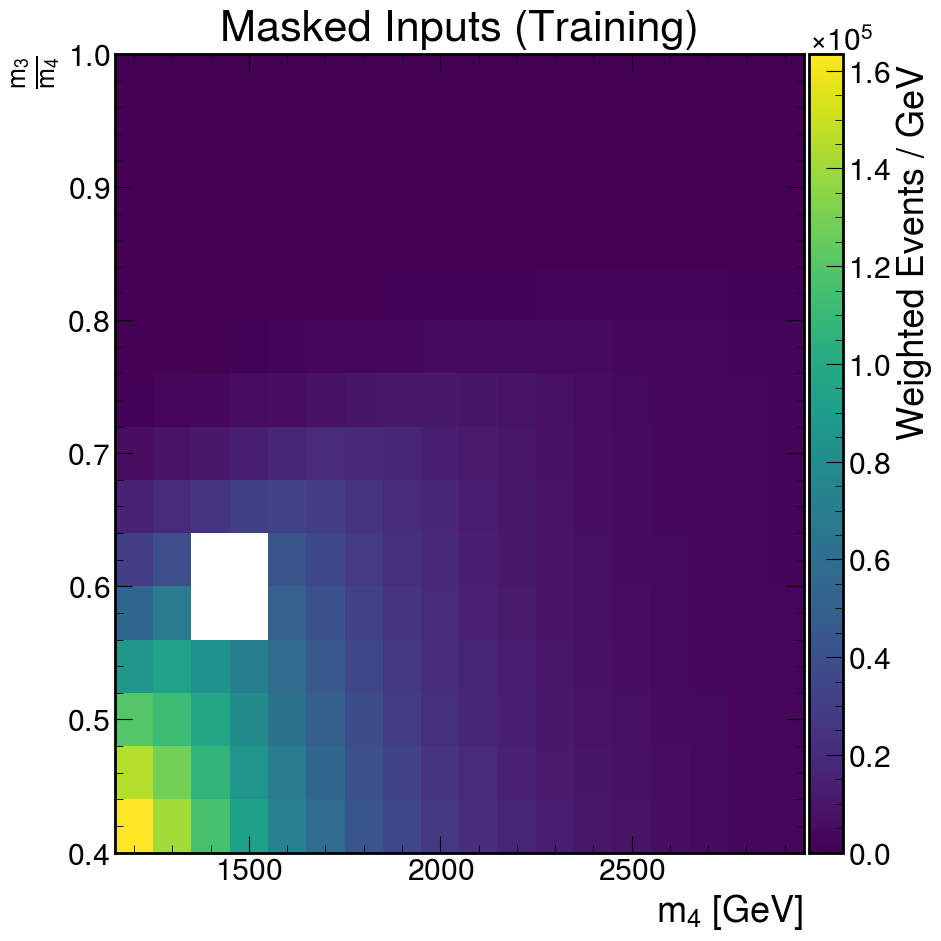

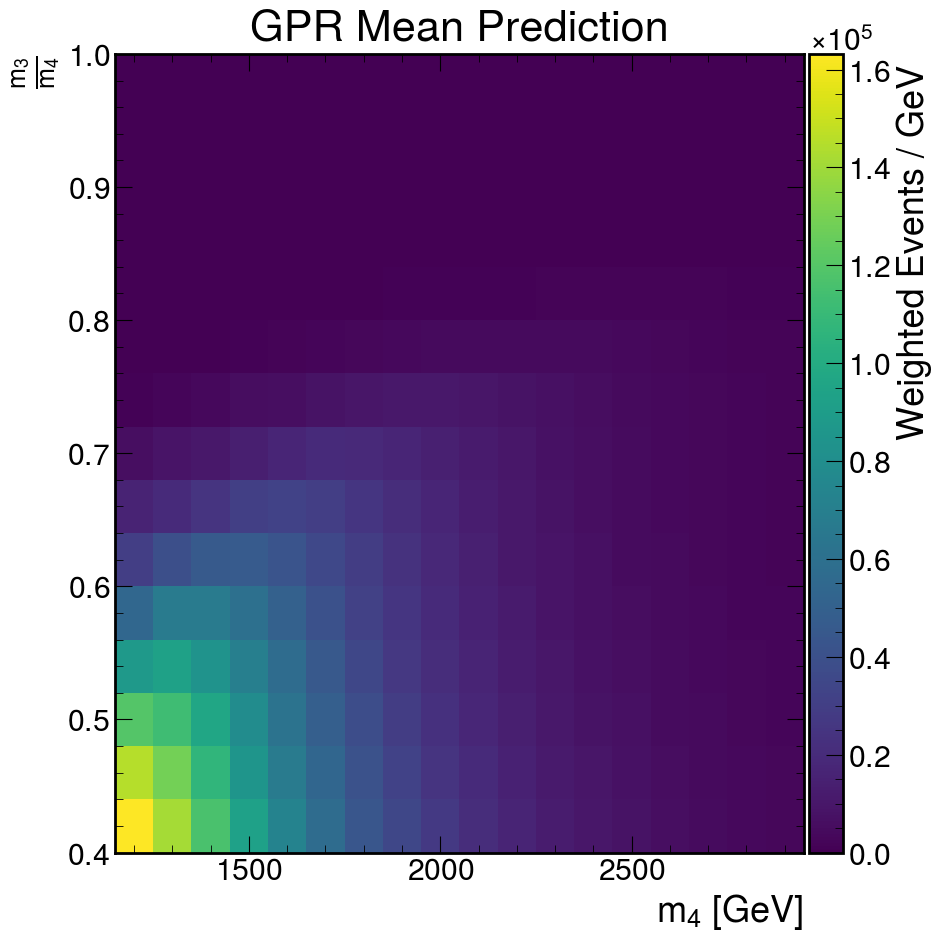

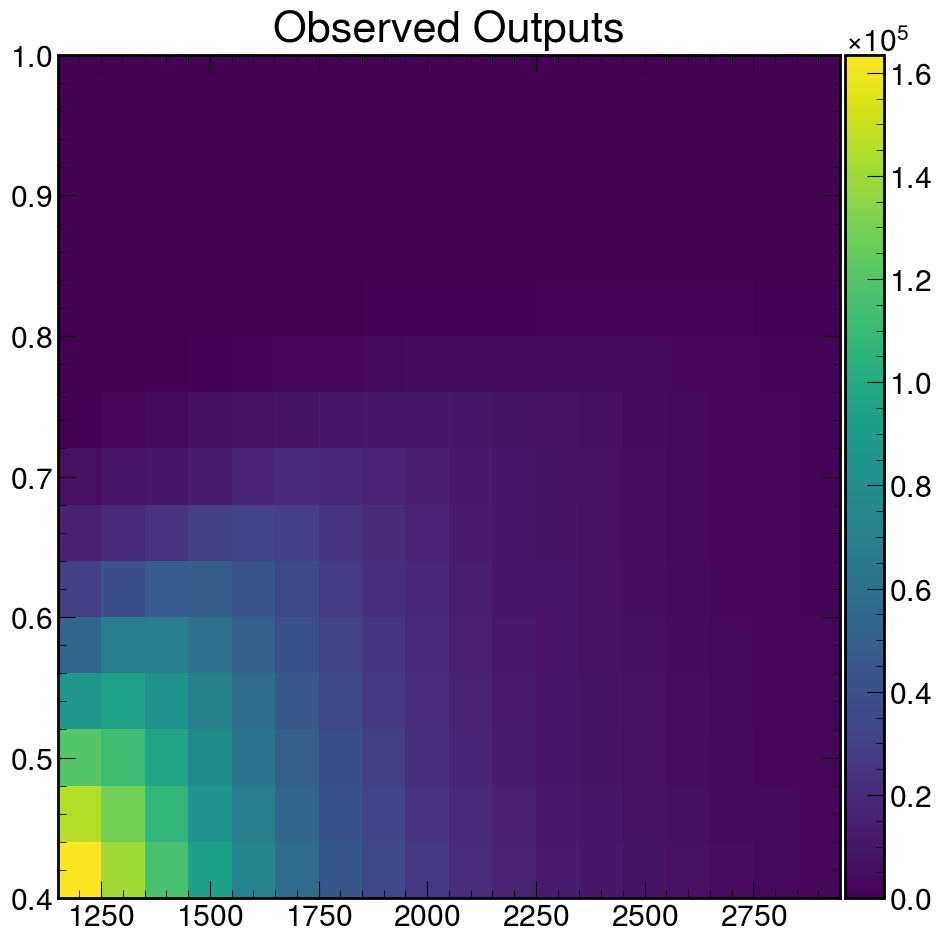

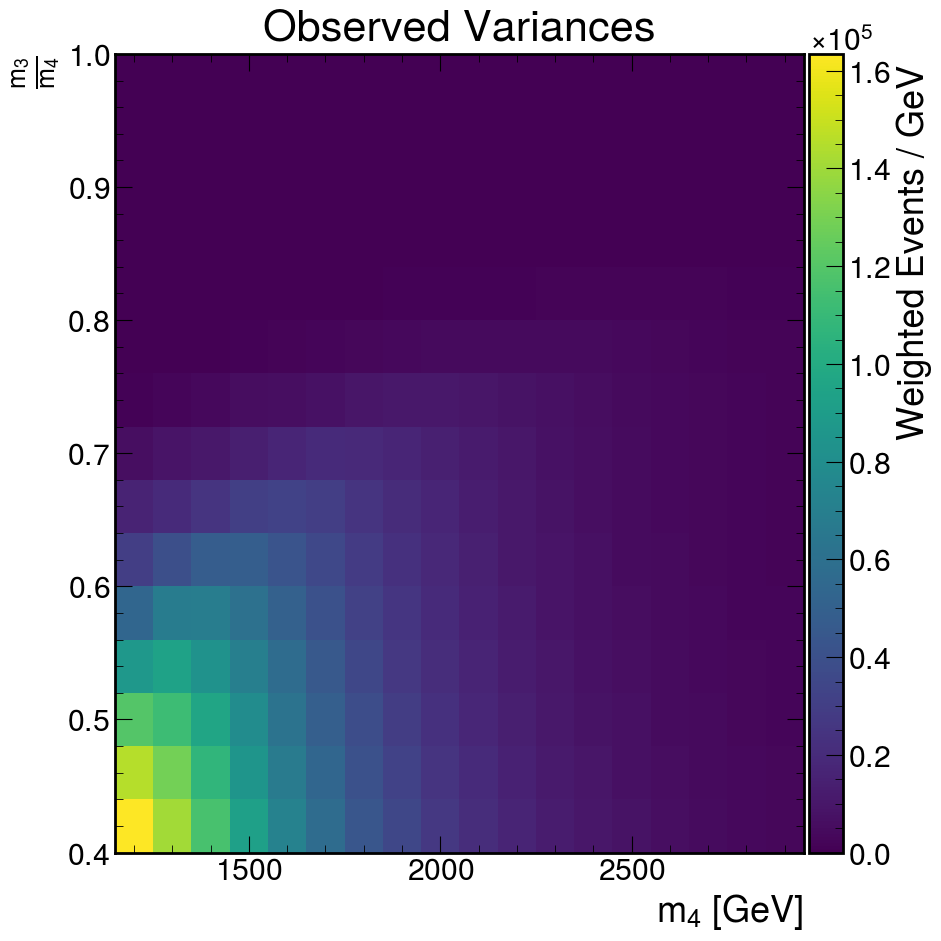

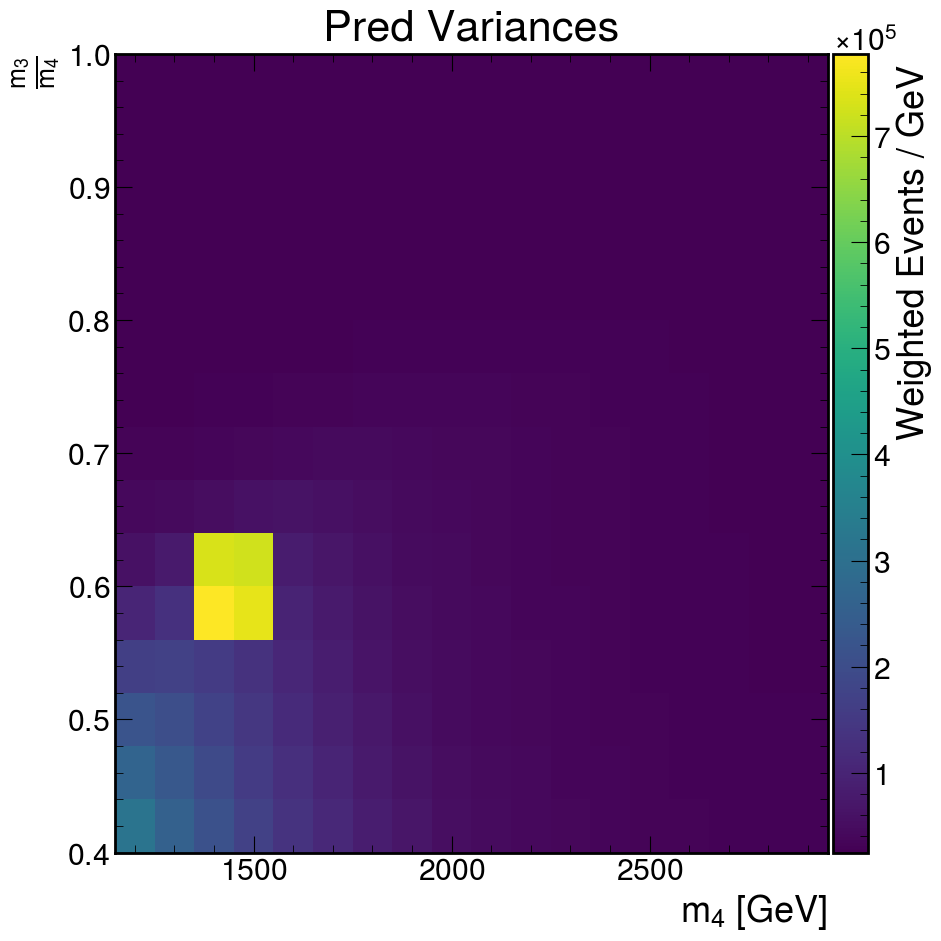

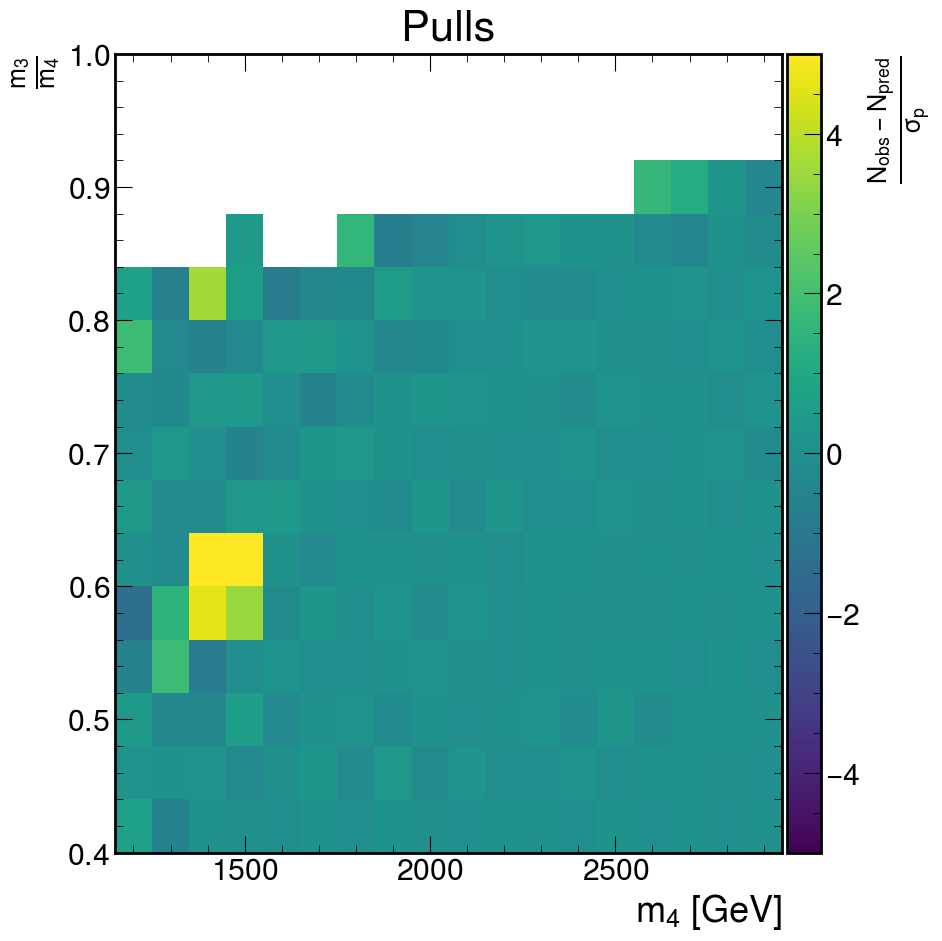

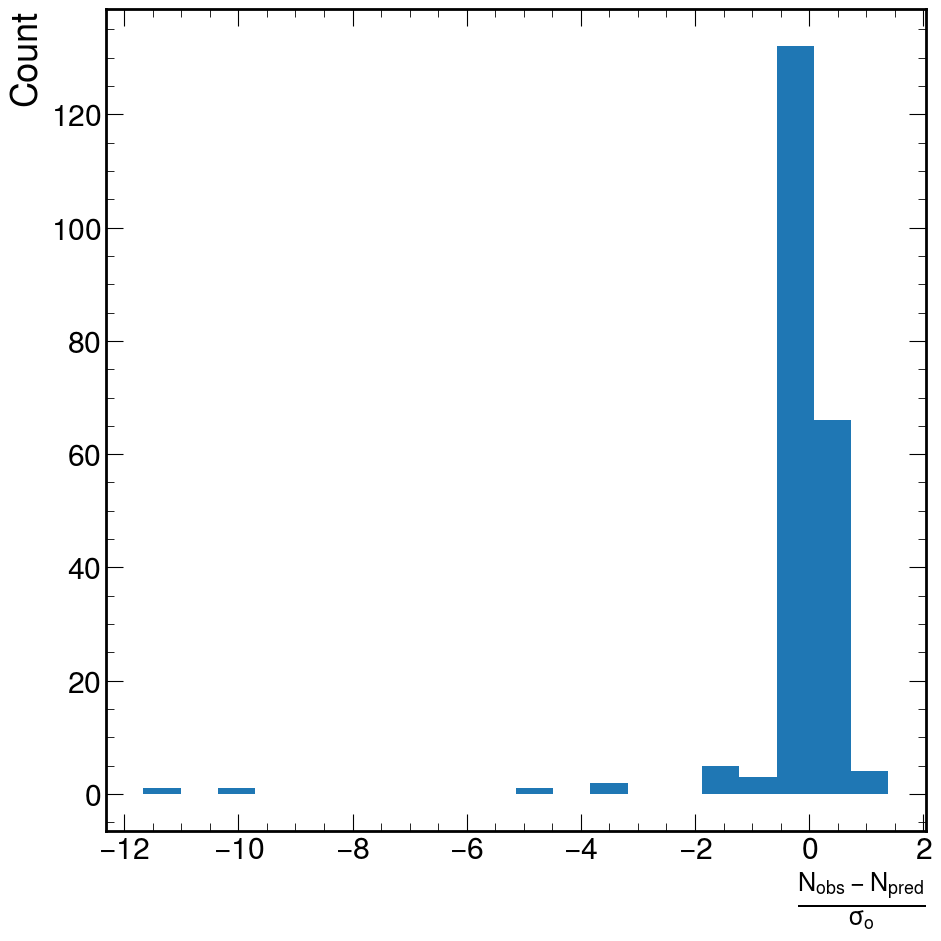

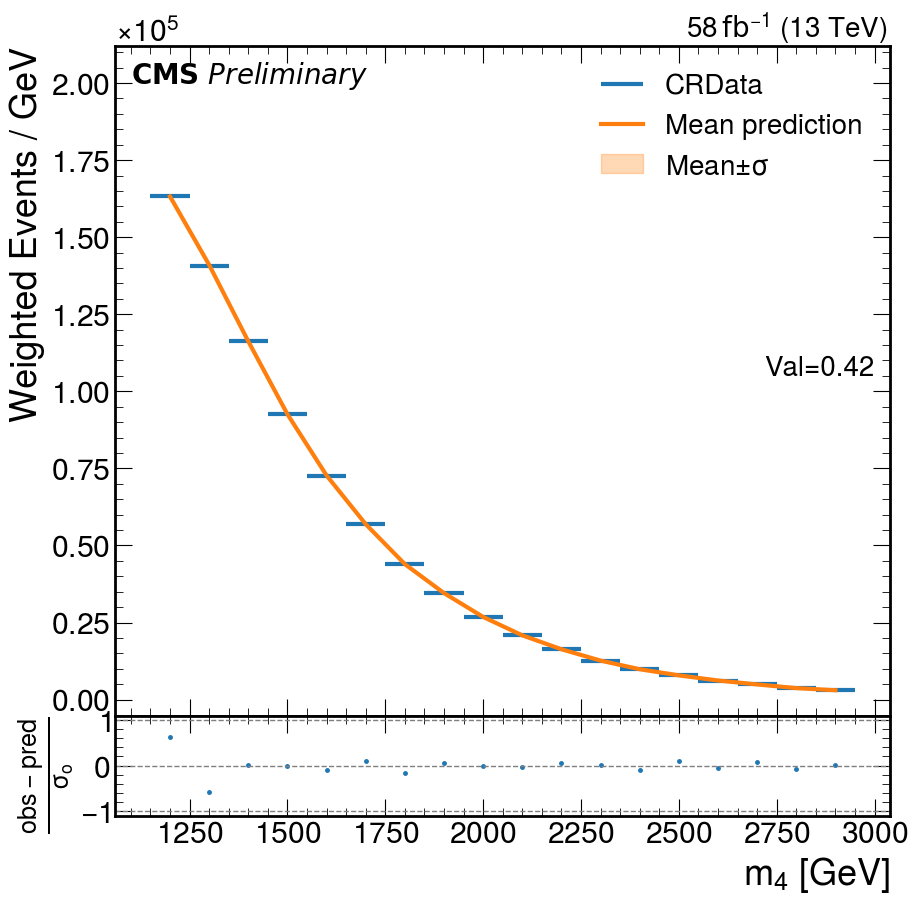

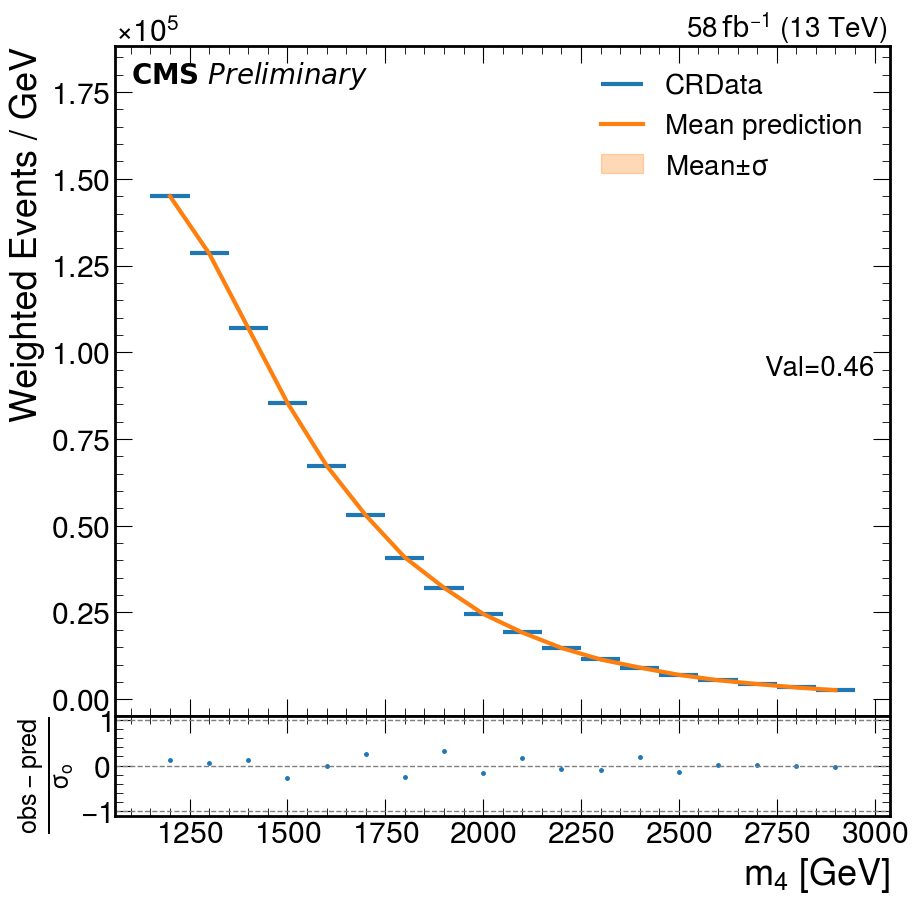

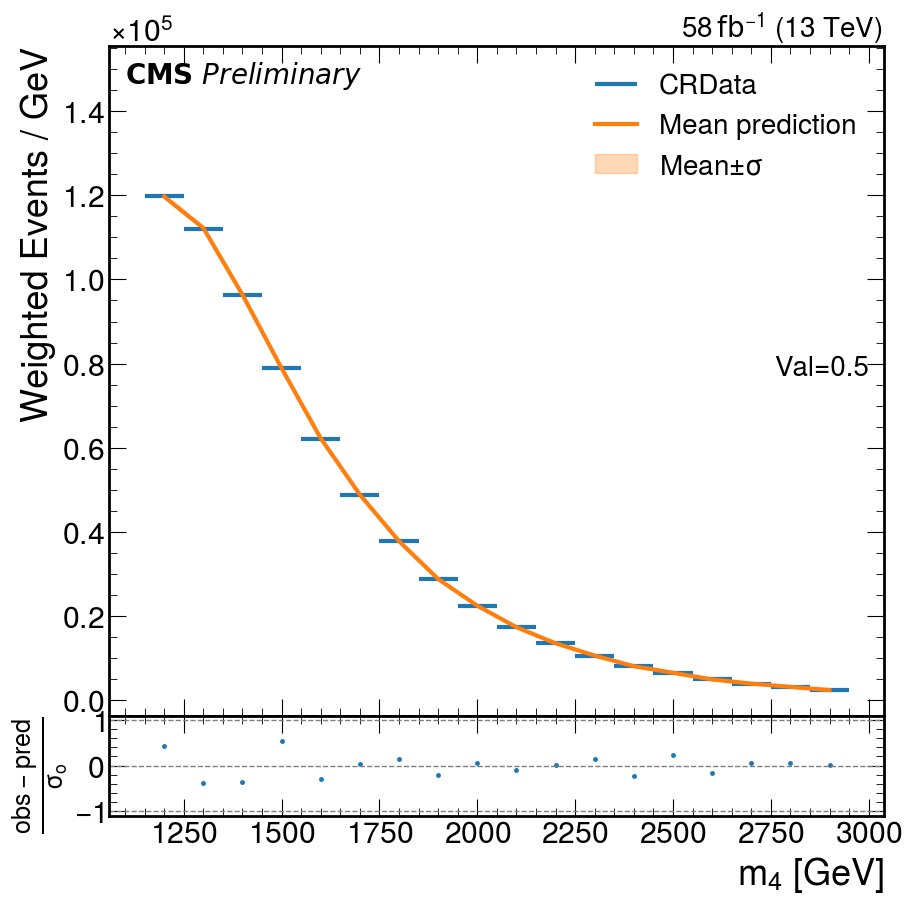

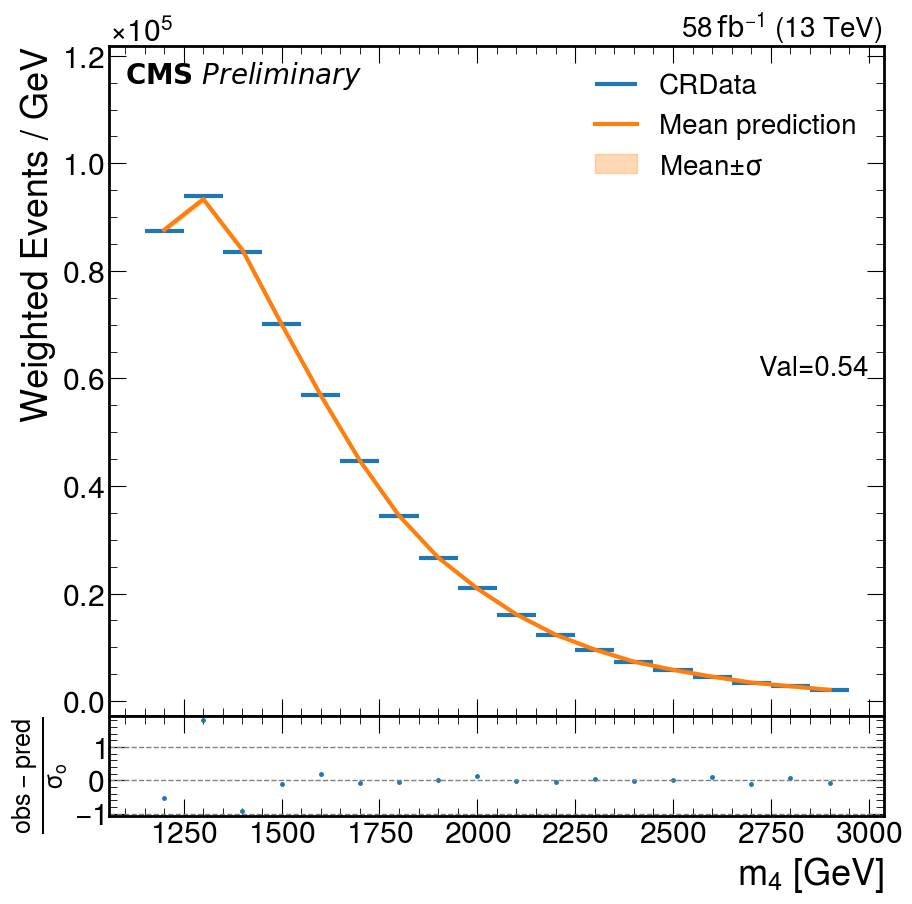

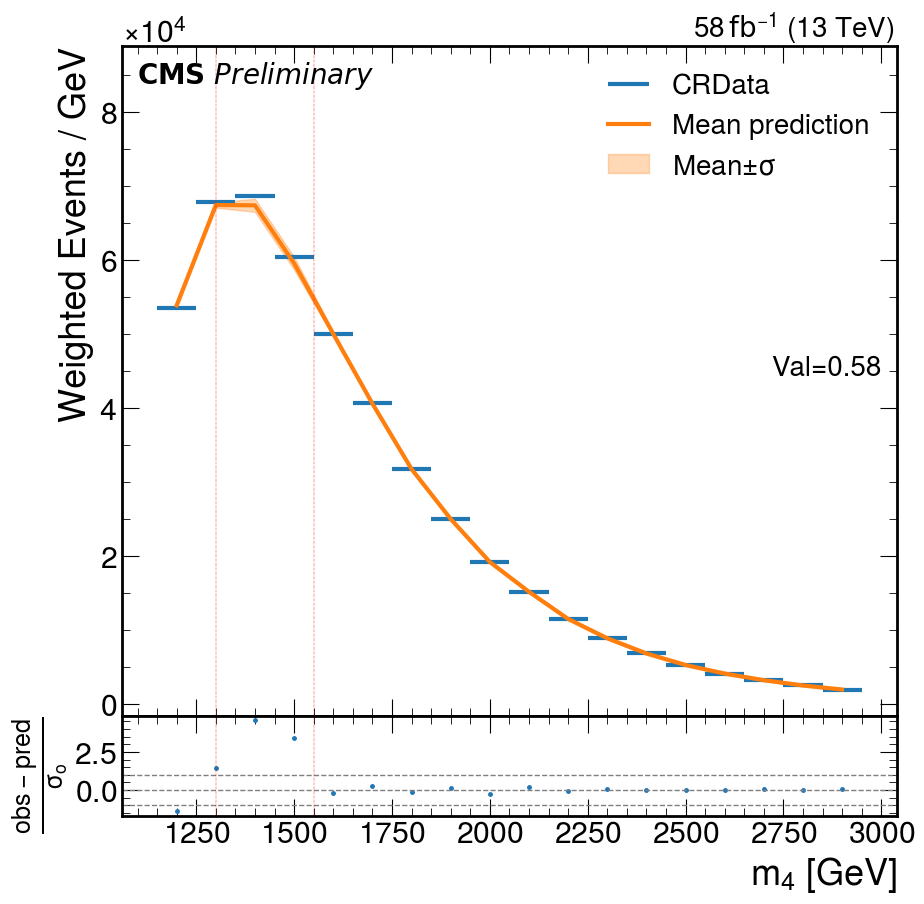

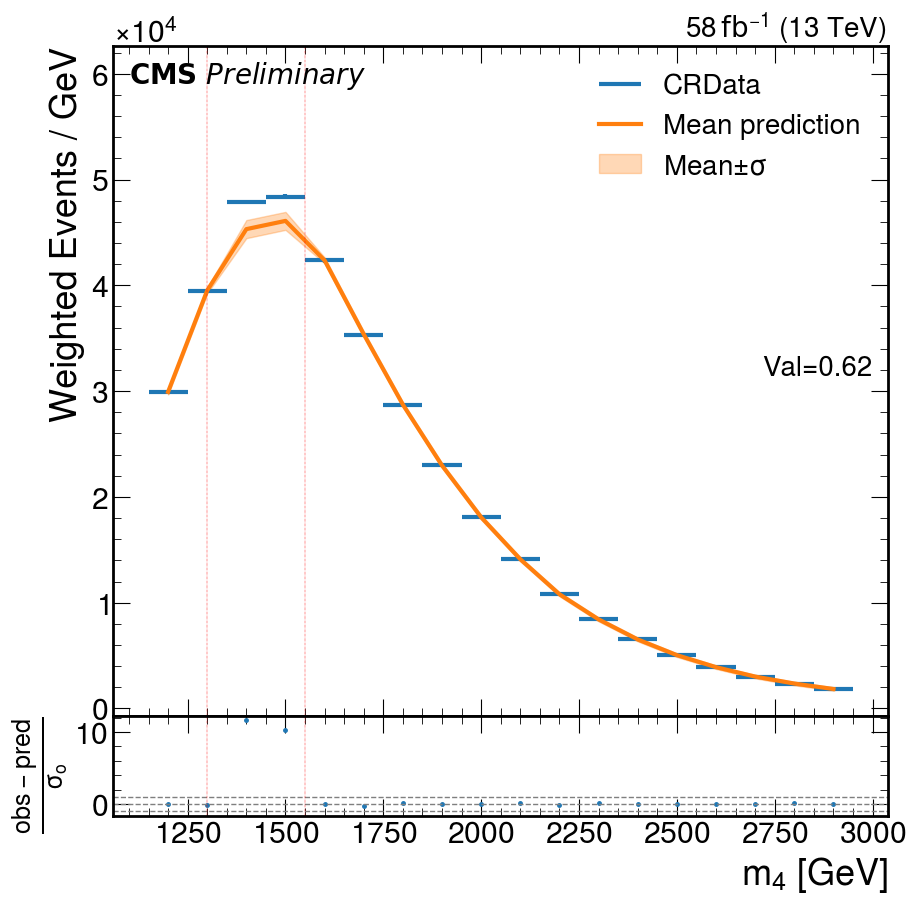

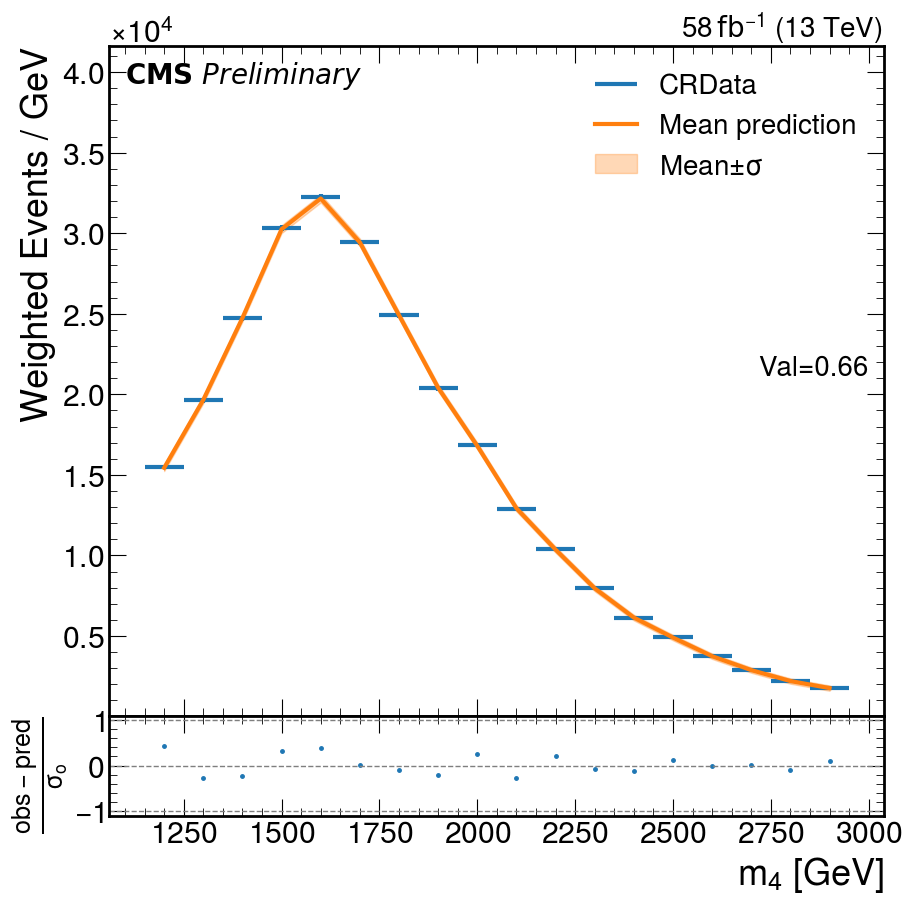

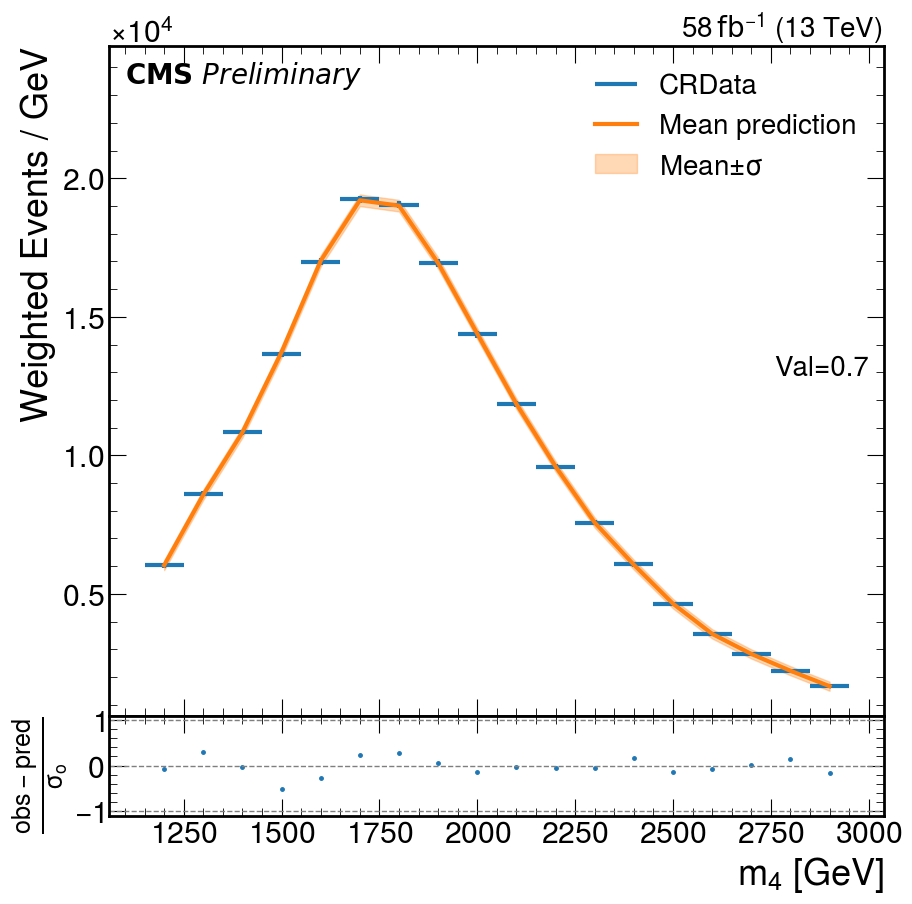

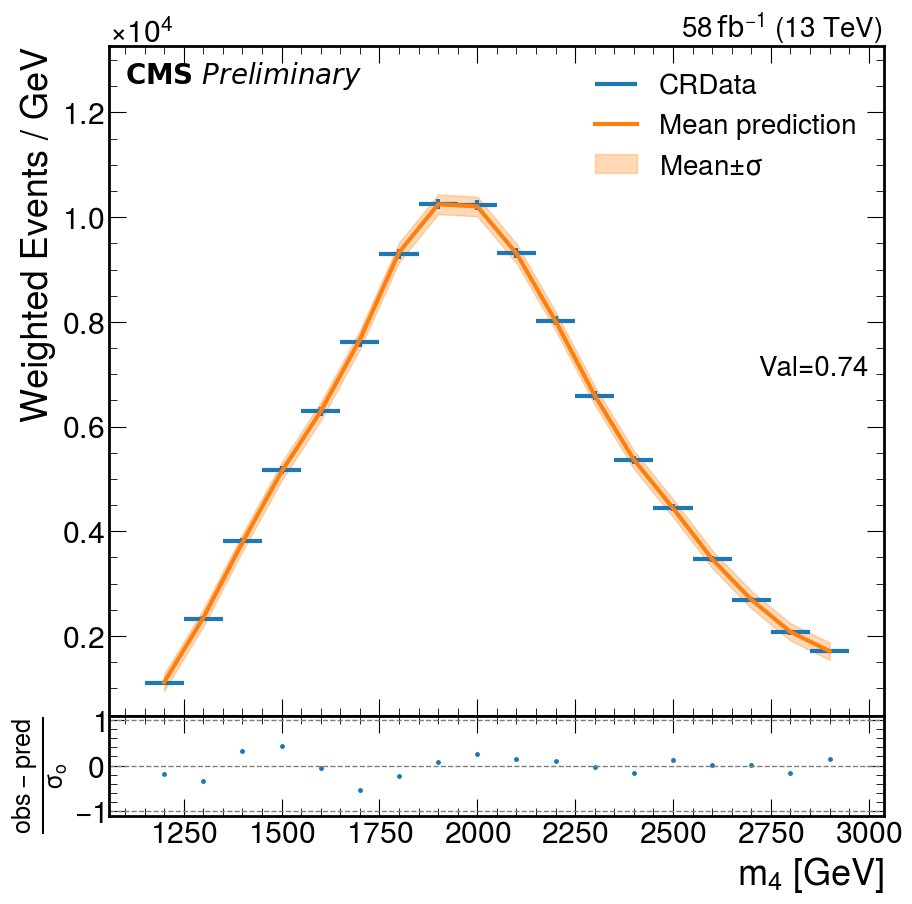

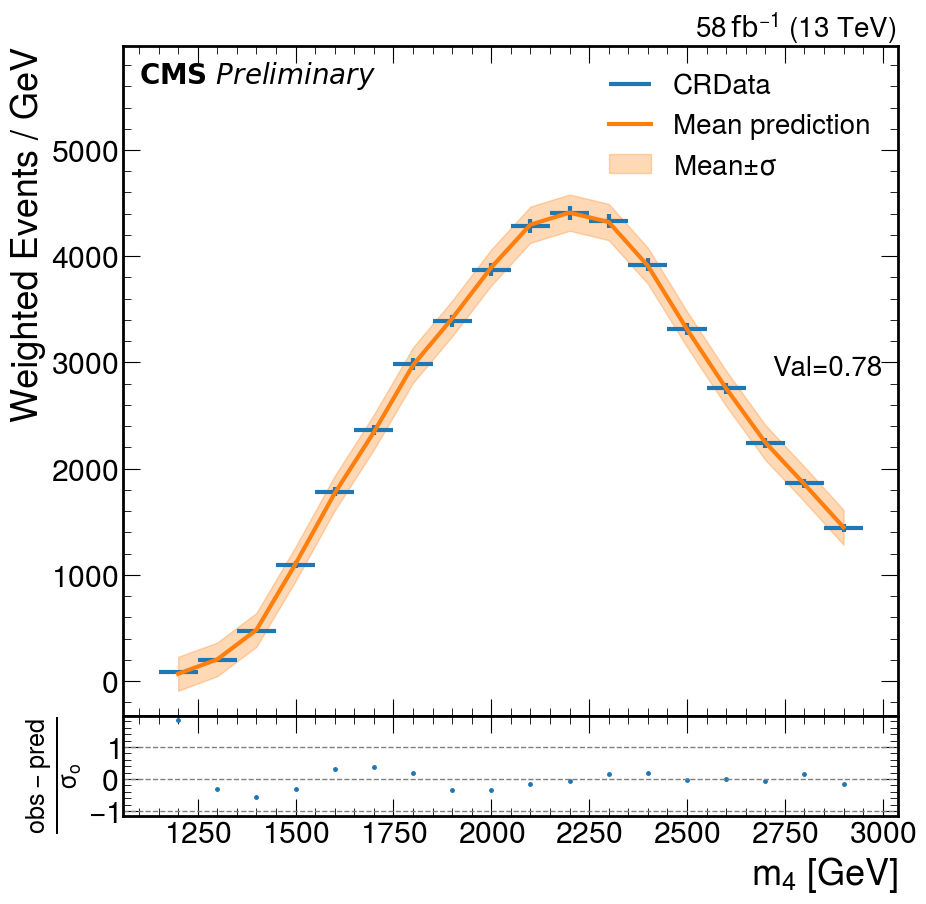

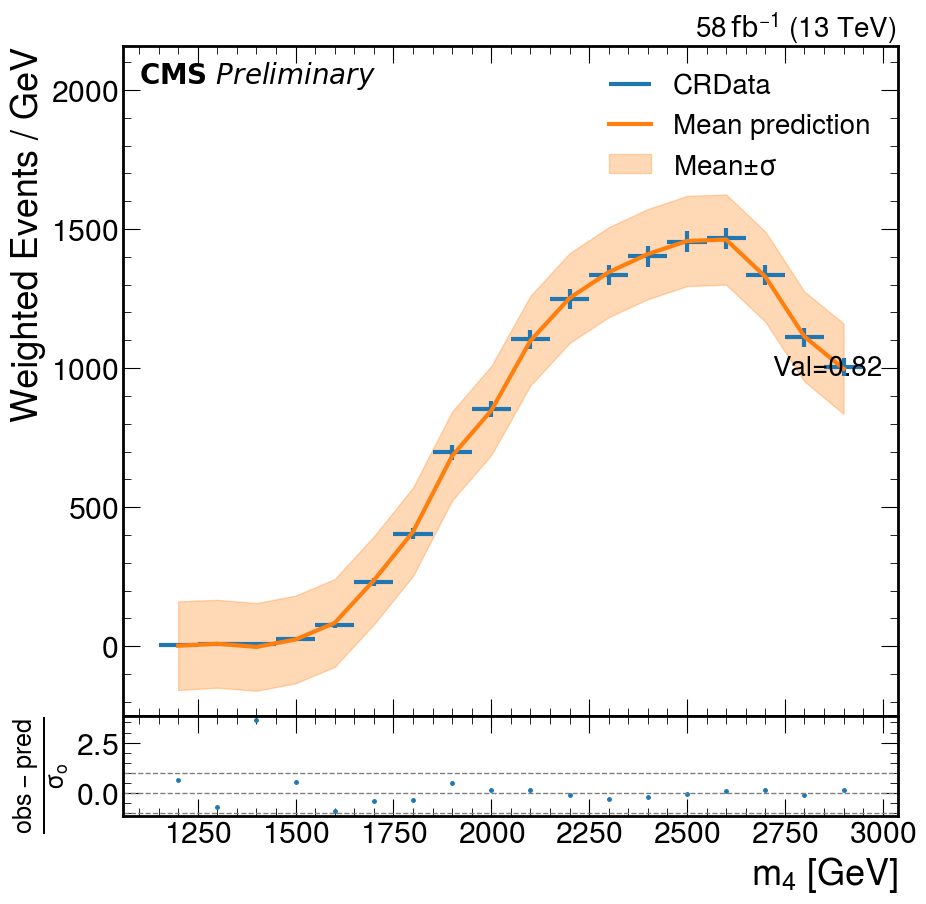

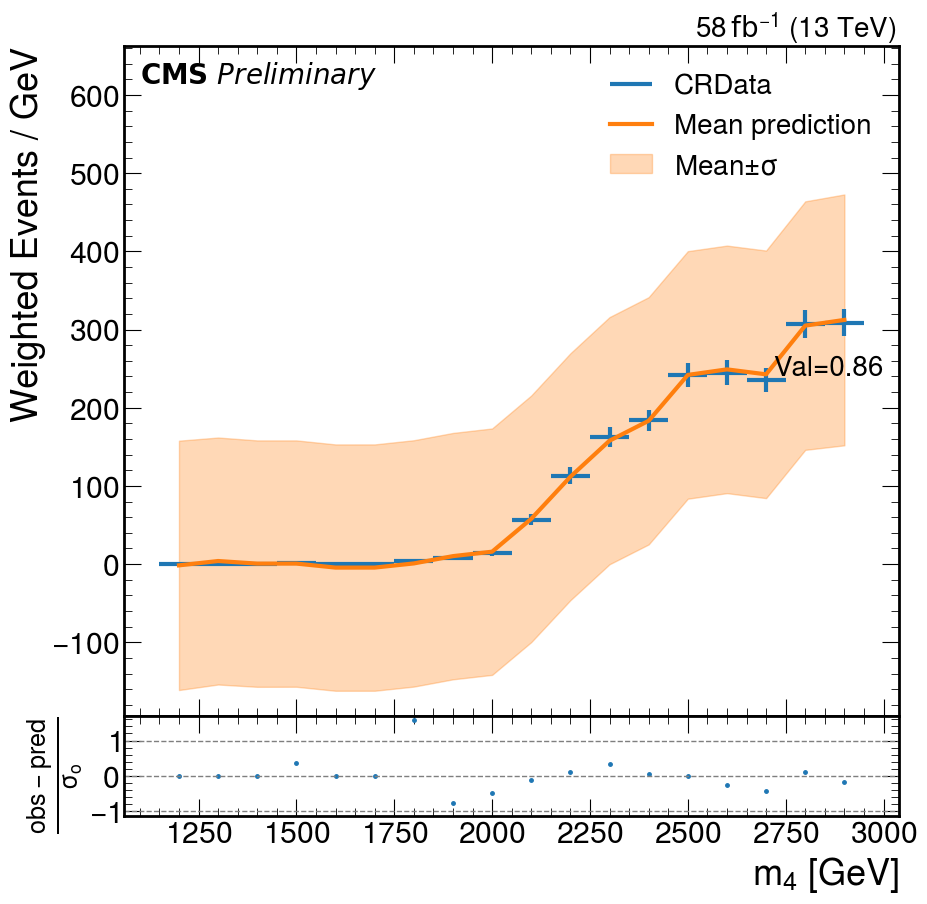

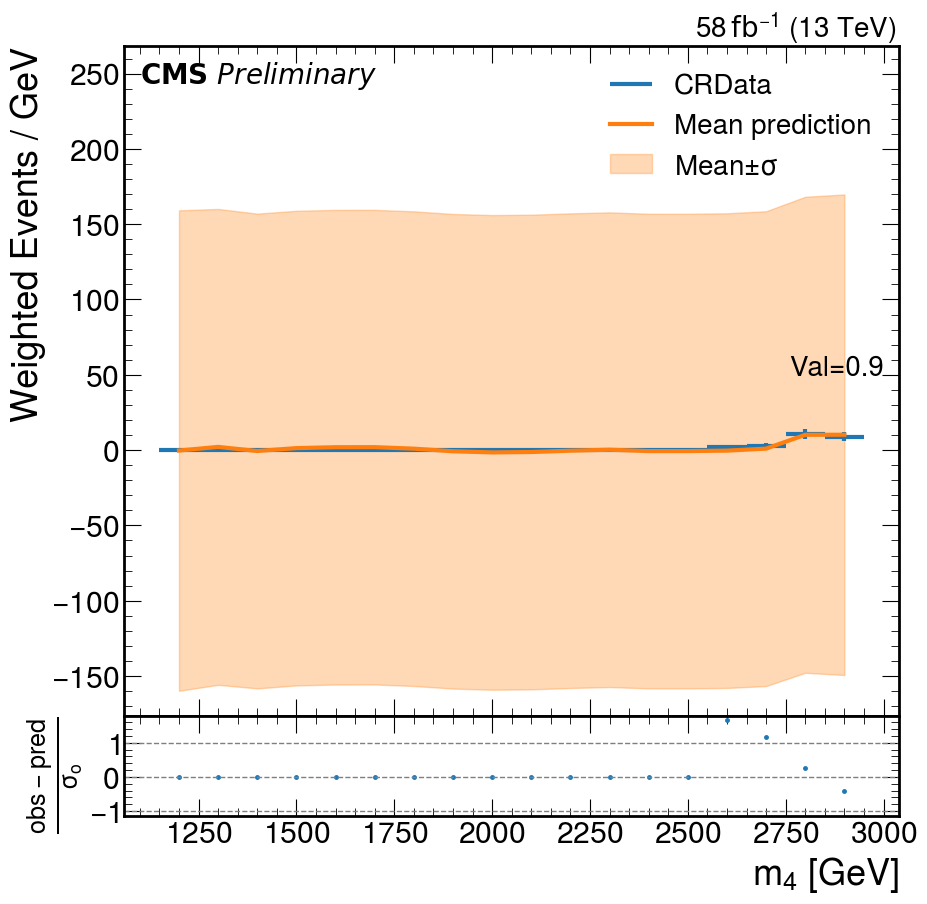

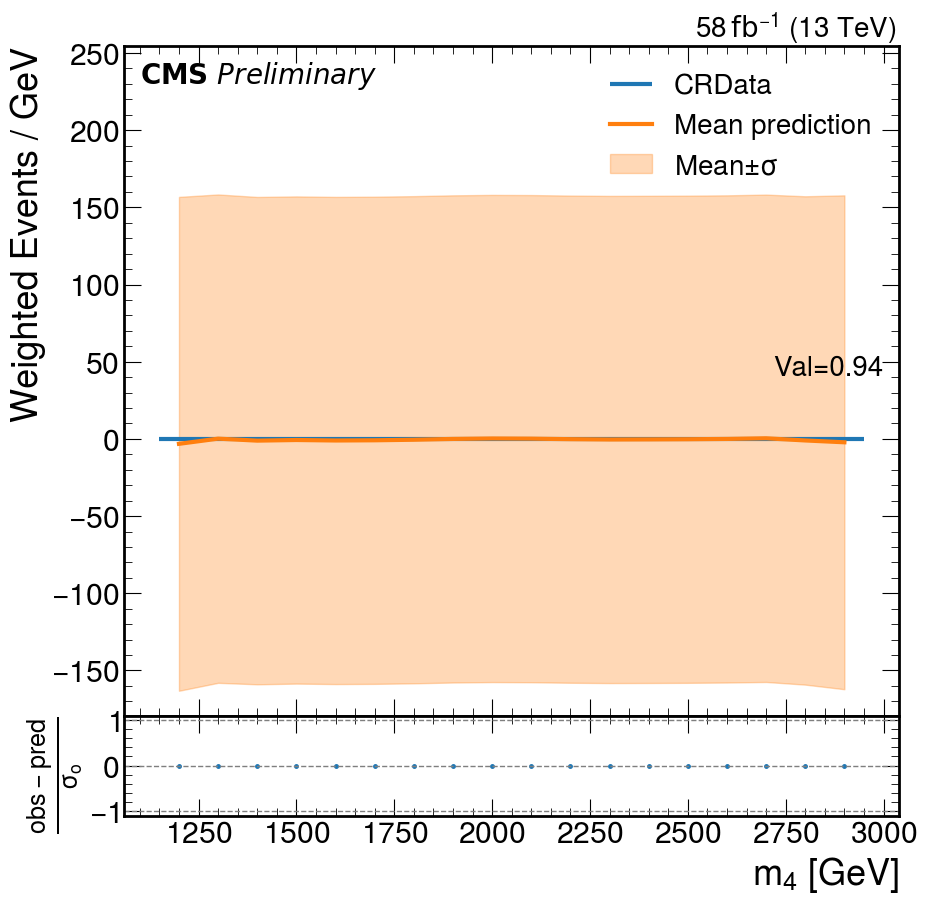

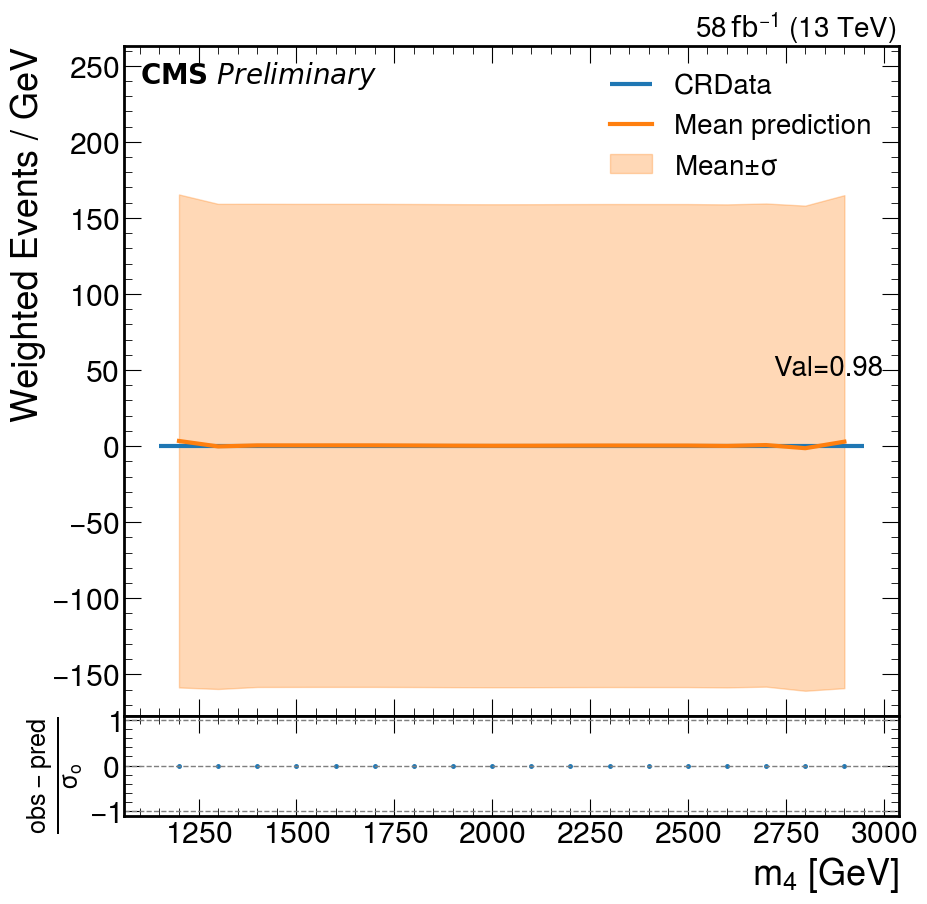

In [471]:
from pathlib import Path
import shutil
base_dir = Path("figures")
this_path = "piece_poly_window_1300_1500__0p55_0p65"
figpath = base_dir / this_path
shutil.rmtree(figpath, ignore_errors=True)
figpath.mkdir(parents=True, exist_ok=True)

from fitting import regression
from gpytorch.kernels import ScaleKernel as SK
from fitting.models import ExactProjGPModel
import fitting.models as models

#model,likelihood = regression.createModel(train, kernel=None)
#model,likelihood = regression.createModel(train, 
#kernel=SK(
#                                              gpytorch.kernels.RBFKernel(ard_num_dims=2) + 
#                                              gpytorch.kernels.LinearKernel(ard_num_dims=2,num_dimensions=2)
#                                          ))
#model,likelihood = regression.createModel(train, kernel=SK(gpytorch.kernels.MaternKernel(ard_num_dims=2)))
model,likelihood = regression.createModel(train, kernel=SK(gpytorch.kernels.PiecewisePolynomialKernel(ard_num_dims=2)))
#model,likelihood = regression.createModel(train, kernel=gpytorch.kernels.SpectralDeltaKernel(num_dims=2, ard_num_dims=2))
#model,likelihood = regression.createModel(train, model_maker= ExactProjGPModel )
#model,likelihood = regression.createModel(train, kernel=SK(models.MatrixRBF()))
#model,likelihood = regression.createModel(train, kernel=SK(models.PeakedRBF(ard_num_dims=2)))

#model,likelihood = regression.createModel(train, kernel=gpytorch.kernels.SpectralMixtureKernel(ard_num_dims=2, num_mixtures=8))
#model,likelihood = regression.createModel(train, kernel=SK(gpytorch.kernels.RQKernel(ard_num_dims=2)))

model,likelihood = regression.optimizeHyperparams(model,likelihood, train, iterations=100)
for n,p in model.named_parameters():
    print(n,p)


pred = regression.getPrediction(model, likelihood, test)



from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools as it

pred_mean = pred.mean * value_scale
pred_var = pred.variance * value_scale ** 2


all_pulls = (pred_mean - raw_test.outputs) / torch.sqrt(raw_test.variances)
all_x2 = (pred_mean - raw_test.outputs)**2 / raw_test.variances
x2 = torch.sum(all_x2)

def addColorbar(ax, vals):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(vals, cax=cax)
    cax.get_yaxis().set_offset_position("left")
    ax.cax = cax


fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, np.ma.masked_where(centers_mask,torch.reshape(raw_test.outputs, centers_mask.shape)))
ax.set_title("Masked Inputs (Training)")
addTitles2D(ax, PlotObject.fromHist(qcd_hist))
fig.savefig(figpath / "training_points.pdf")

fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, pred_mean)
ax.set_title("GPR Mean Prediction")
addTitles2D(ax, PlotObject.fromHist(qcd_hist))
fig.savefig(figpath / "gpr_mean.pdf")


fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, raw_test.outputs)
ax.set_title("Observed Outputs")
fig.savefig(figpath / "observed_outputs.pdf")



#drawAs2DHist(ax[1,1], PlotObject.fromHist(sig_hist))
#addTitles2D(ax[1,1], PlotObject.fromHist(sig_hist))
#ax[1,1].set_title("Signal MC")

fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, raw_test.variances)
ax.set_title("Observed Variances")
addTitles2D(ax, PlotObject.fromHist(qcd_hist))

fig.savefig(figpath / "observed_variances.pdf")


fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, pred_var)
ax.set_title("Pred Variances")
addTitles2D(ax, PlotObject.fromHist(qcd_hist))

fig.savefig(figpath / "predicted_variances.pdf")


fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, (raw_test.outputs - pred_mean)/ torch.sqrt(raw_test.variances))
f.set_clim(-5,5)
ax.set_title("Pulls")
addTitles2D(ax, PlotObject.fromHist(qcd_hist))
ax.cax.set_ylabel(r"$\frac{N_{obs}-N_{pred}}{\sigma_{p}}$")
fig.savefig(figpath / "pulls.pdf")



import uhi
fig, ax=plt.subplots(figsize=(10,10), layout="tight")
p = PlotObject.fromHist(uhi.numpy_plottable.ensure_plottable_histogram(np.histogram(all_pulls[torch.abs(all_pulls) < np.inf], bins=20)))
drawAs1DHist(ax, p, yerr=False)
ax.set_xlabel(r"$\frac{N_{obs}-N_{pred}}{\sigma_{o}}$")
ax.set_ylabel("Count")
fig.savefig(figpath / "pulls_hist.pdf")


import fitting.plot_tools as fpt
import analyzer.plotting as plotting
from pathlib import Path
import importlib

importlib.reload(fpt)
dim = 1

(figpath /"slices" / f"along_{dim}").mkdir(parents=True, exist_ok=True)
for val, f, ax in fpt.createSlices(
    (pred.mean * value_scale, pred.variance * value_scale**2),
    raw_test
    , observed_title="CRData", window_2d=window, dim=dim):
    plotting.addTitles1D(ax, plotting.PlotObject.fromHist(qcd_hist[:,sum]))
    f.savefig(figpath /"slices" / f"along_{dim}" /  (f"slice_{round(float(val),3)}".replace(".","p") + ".pdf"))
    #plt.close(f)
    
    

